<a href="https://colab.research.google.com/github/Girishachari/NNDL-Mini-Project/blob/main/NNDL_Mini_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Extracting...
Dataset ready.
Num users: 610, Num movies: 9724, num ratings: 100836


Model: "NCF_simple"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ user_input          │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ movie_input         │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ user_embedding      │ (None, 1, 32)     │     19,520 │ user_input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ movie_embedding     │ (None, 1, 32)     │    311,168 │ movie_input[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ user_flatten        │ (None, 32)        │          0 │ user_embedding[0… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ movie_flatten       │ (None, 32)        │          0 │ movie_embedding[… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot (Dot)           │ (None, 1)         │          0 │ user_flatten[0][… │
│                     │                   │            │ movie_flatten[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 32)        │         64 │ dot[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rating_pred (Dense) │ (None, 1)         │         33 │ dense_1[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 330,785 (1.26 MB)

 Trainable params: 330,785 (1.26 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1135/1135 - 7s - 7ms/step - loss: 2.5432 - val_loss: 0.8963
Epoch 2/10
1135/1135 - 5s - 4ms/step - loss: 0.5924 - val_loss: 0.8655
Epoch 3/10
1135/1135 - 5s - 4ms/step - loss: 0.3089 - val_loss: 0.9232
Epoch 4/10
1135/1135 - 5s - 5ms/step - loss: 0.2031 - val_loss: 0.9691
Epoch 5/10
1135/1135 - 4s - 4ms/step - loss: 0.1647 - val_loss: 1.0051
Epoch 6/10
1135/1135 - 4s - 4ms/step - loss: 0.1458 - val_loss: 1.0361
Epoch 7/10
1135/1135 - 5s - 4ms/step - loss: 0.1290 - val_loss: 1.0609
Epoch 8/10
1135/1135 - 4s - 4ms/step - loss: 0.1153 - val_loss: 1.0810
Epoch 9/10
1135/1135 - 4s - 4ms/step - loss: 0.1045 - val_loss: 1.0974
Epoch 10/10
1135/1135 - 5s - 4ms/step - loss: 0.0963 - val_loss: 1.1150


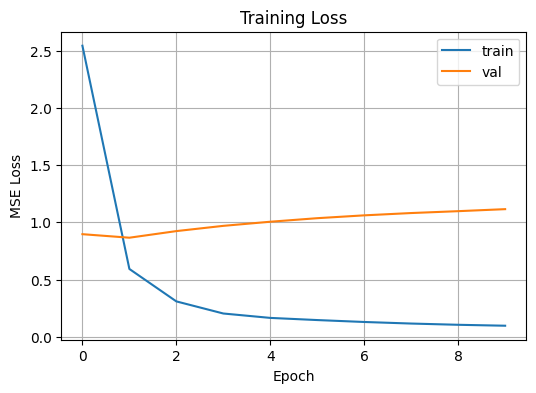


Recommendations for userId (original) = 1
 movieId                                                   title  predicted_rating
    4787                                  Little Man Tate (1991)          4.887251
   84273                        Zeitgeist: Moving Forward (2011)          4.887181
    4901                                         Spy Game (2001)          4.887116
     799                                 Frighteners, The (1996)          4.887081
   61026                               Red Cliff (Chi bi) (2008)          4.887057
   91529                           Dark Knight Rises, The (2012)          4.887032
    2005                                     Goonies, The (1985)          4.886998
   79702                      Scott Pilgrim vs. the World (2010)          4.886971
   27592 Sympathy for Mr. Vengeance (Boksuneun naui geot) (2002)          4.886968
    2313                                Elephant Man, The (1980)          4.886966


In [1]:
"""
movie_recommender_ncf.py
End-to-end Neural Collaborative Filtering implementation (MovieLens - small)
Modules:
 1. Input Data Acquisition
 2. Data Preprocessing & ID Mapping
 3. Embedding & Model Construction
 4. Training & Validation
 5. Prediction Generation
 6. Recommendation Output (Top-N)
"""

# SYSTEM REQUIREMENTS (software):
# pip install numpy pandas scikit-learn tensorflow matplotlib

import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Embedding, Flatten, Dot, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import zipfile
import urllib.request

# -----------------------------
# 1. Input Data Acquisition Module
# -----------------------------
def download_and_extract_movielens(target_dir="ml-latest-small"):
    """Download MovieLens (small) and extract. Skips if already present."""
    url = "https://files.grouplens.org/datasets/movielens/ml-latest-small.zip"
    zip_path = "ml-latest-small.zip"
    if os.path.exists(target_dir):
        print(f"Dataset already present in ./{target_dir}")
        return
    print("Downloading MovieLens small dataset...")
    urllib.request.urlretrieve(url, zip_path)
    print("Extracting...")
    with zipfile.ZipFile(zip_path, "r") as z:
        z.extractall(".")
    os.remove(zip_path)
    print("Dataset ready.")


# -----------------------------
# 2. Data Preprocessing & ID Mapping Module
# -----------------------------
def load_and_preprocess(ratings_path="ml-latest-small/ratings.csv",
                        movies_path="ml-latest-small/movies.csv",
                        test_size=0.2, random_state=42):
    """
    Loads CSVs, maps original IDs to contiguous indices (0..N-1) for embeddings,
    and returns train/test splits and metadata.
    """
    ratings = pd.read_csv(ratings_path)
    movies = pd.read_csv(movies_path)

    # Map userId and movieId to continuous indices
    unique_user_ids = ratings["userId"].unique()
    unique_movie_ids = ratings["movieId"].unique()

    user_id_map = {orig_id: idx for idx, orig_id in enumerate(unique_user_ids)}
    movie_id_map = {orig_id: idx for idx, orig_id in enumerate(unique_movie_ids)}

    ratings["user"] = ratings["userId"].map(user_id_map)
    ratings["movie"] = ratings["movieId"].map(movie_id_map)

    num_users = len(unique_user_ids)
    num_movies = len(unique_movie_ids)
    print(f"Num users: {num_users}, Num movies: {num_movies}, num ratings: {len(ratings)}")

    # Prepare model inputs and targets
    X = ratings[["user", "movie"]].copy()
    y = ratings["rating"].astype(np.float32)

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )

    meta = {
        "movies_df": movies,
        "user_id_map": user_id_map,
        "movie_id_map": movie_id_map,
        "reverse_movie_map": {v: k for k, v in movie_id_map.items()},
        "num_users": num_users,
        "num_movies": num_movies
    }

    return X_train, X_test, y_train, y_test, meta


# -----------------------------
# 3. Embedding & Model Construction Module
# -----------------------------
def build_ncf_model(num_users, num_movies, embedding_dim=32, dense_units=32, lr=0.001):
    """
    Constructs the NCF-like model:
    - user and movie embeddings
    - dot product of embeddings
    - small MLP (Dense) on top
    - single output predicting rating (regression)
    """
    user_input = Input(shape=(1,), name="user_input")
    movie_input = Input(shape=(1,), name="movie_input")

    user_emb = Embedding(input_dim=num_users, output_dim=embedding_dim,
                         name="user_embedding")(user_input)    # (batch, 1, dim)
    movie_emb = Embedding(input_dim=num_movies, output_dim=embedding_dim,
                          name="movie_embedding")(movie_input)

    user_vec = Flatten(name="user_flatten")(user_emb)   # (batch, dim)
    movie_vec = Flatten(name="movie_flatten")(movie_emb)

    # Basic interaction
    dot = Dot(axes=1, name="dot")([user_vec, movie_vec])  # (batch, 1)

    # MLP head to learn non-linear patterns
    dense = Dense(dense_units, activation="relu", name="dense_1")(dot)
    out = Dense(1, activation="linear", name="rating_pred")(dense)

    model = Model(inputs=[user_input, movie_input], outputs=out, name="NCF_simple")
    model.compile(optimizer=Adam(learning_rate=lr), loss="mse")
    return model


# -----------------------------
# 4. Training & Validation Module
# -----------------------------
def train_model(model, X_train, y_train, epochs=10, batch_size=64, val_split=0.1):
    history = model.fit(
        [X_train["user"], X_train["movie"]],
        y_train,
        validation_split=val_split,
        epochs=epochs,
        batch_size=batch_size,
        verbose=2
    )
    return history


def plot_history(history):
    plt.figure(figsize=(6,4))
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='val')
    plt.title("Training Loss")
    plt.xlabel("Epoch")
    plt.ylabel("MSE Loss")
    plt.legend()
    plt.grid(True)
    plt.show()


# -----------------------------
# 5. Prediction Generation Module
# -----------------------------
def predict_ratings_for_user(model, user_orig_id, meta):
    """
    Predict ratings for all movies for a specific original userId (not internal index).
    If user_orig_id not in training users, raises KeyError.
    Returns a DataFrame with columns: ['movieId', 'title', 'predicted_rating'].
    """
    user_id_map = meta["user_id_map"]
    movie_id_map = meta["movie_id_map"]
    reverse_movie_map = meta["reverse_movie_map"]
    movies_df = meta["movies_df"]
    num_movies = meta["num_movies"]

    if user_orig_id not in user_id_map:
        raise KeyError(f"userId {user_orig_id} not found in map.")

    user_index = user_id_map[user_orig_id]
    movie_indices = np.arange(num_movies)

    # Predict
    preds = model.predict([np.full(shape=num_movies, fill_value=user_index), movie_indices], verbose=0)
    preds = preds.flatten()

    # Map internal movie indices back to original movieId
    original_movie_ids = [reverse_movie_map[i] for i in movie_indices]

    pred_df = pd.DataFrame({
        "movieId": original_movie_ids,
        "predicted_rating": preds
    })

    # Merge with metadata to get titles (left join ensures only movies present in movies.csv)
    merged = pd.merge(movies_df, pred_df, on="movieId", how="left")
    merged["predicted_rating"] = merged["predicted_rating"].fillna(-np.inf)  # if any missing, push to bottom
    return merged[["movieId", "title", "predicted_rating"]]


# -----------------------------
# 6. Recommendation Output Module (Final Prediction)
# -----------------------------
def get_top_n_recommendations(predictions_df, n=10):
    """Return top-n movies sorted by predicted_rating."""
    topn = predictions_df.sort_values(by="predicted_rating", ascending=False).head(n)
    return topn.reset_index(drop=True)


# -----------------------------
# Example Usage (end-to-end)
# -----------------------------
if __name__ == "__main__":
    # 1. Download dataset (skip if already present)
    download_and_extract_movielens()

    # 2. Load & preprocess
    X_train, X_test, y_train, y_test, meta = load_and_preprocess()

    # 3. Build model
    model = build_ncf_model(num_users=meta["num_users"], num_movies=meta["num_movies"],
                            embedding_dim=32, dense_units=32, lr=0.001)
    model.summary()

    # 4. Train
    history = train_model(model, X_train, y_train, epochs=10, batch_size=64, val_split=0.1)

    # 5. Plot training history
    plot_history(history)

    # 6. Predict & recommend for a sample user
    # Pick a userId from the original MovieLens user IDs (not internal index). For demo, use first user in map:
    sample_user_orig_id = list(meta["user_id_map"].keys())[0]
    print(f"\nRecommendations for userId (original) = {sample_user_orig_id}")
    preds_df = predict_ratings_for_user(model, sample_user_orig_id, meta)
    top10 = get_top_n_recommendations(preds_df, n=10)
    print(top10.to_string(index=False))
